### Problem 3.1

In [1]:
from scipy.fftpack import dct, idct
from sklearn.linear_model import LassoLars
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# Load the .mat file
data = loadmat('problem3_1.mat')
n = data['n'].flatten() - 1 # Sample indices
y = data['x'].flatten() # Sample values

l = 2**9 # Signal length  
N = len(n) # Number of samples

# Construct the sensing matrix from indices and compute Theta
C = np.zeros((N, l))
for i in range(N):
    C[i, n[i]] = 1
Theta = idct(C) 

# Fit LassoLars model
model = LassoLars(alpha=0.01, fit_intercept=False, max_iter=1000)
model.fit(Theta, y)
a = model.coef_ # Extract solutions
x = dct(a)  # Reconstruct signal

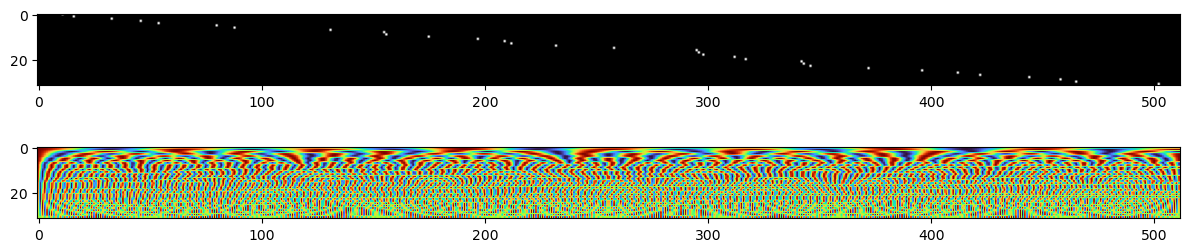

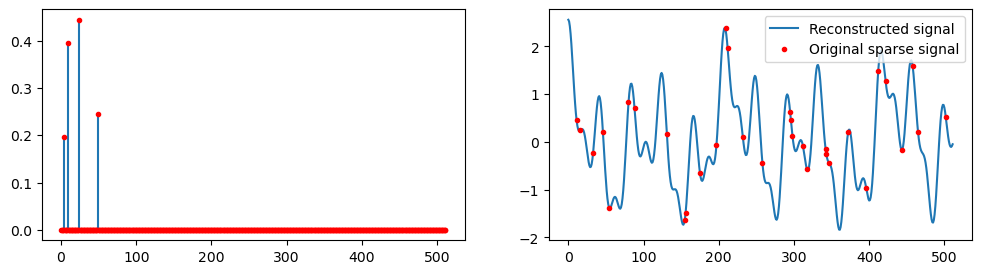

Number of non-zero coefficients: 4
Indices of the non-zero coefficients: [ 5 10 25 50]
Values of the non-zero coefficients: [0.19566357 0.39440592 0.44431338 0.24527572]


In [2]:

# Plot the sensing matrix
plt.figure(1, figsize=(12, 3))
plt.subplot(2, 1, 1)
plt.imshow(C, cmap='gray')
#plt.title(r'Sensing matrix $\mathbf{C}$')

# Plot theta
plt.subplot(2, 1, 2)
plt.imshow(Theta, cmap='turbo')
#plt.title(r'$\boldsymbol{\Theta}$')

plt.tight_layout()
plt.savefig('problem3_1_matrices.png', bbox_inches='tight', dpi=300)
plt.show()

# Plot the results
plt.figure(4, figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.stem(a, markerfmt='r.', basefmt=' ')
#plt.xlabel(r'$j$')
#plt.ylabel(r'$a_j$')

plt.subplot(1, 2, 2)
plt.plot(x, label = 'Reconstructed signal')
plt.plot(n, y, 'r.', label = 'Original sparse signal')
#plt.xlabel(r'$n$')
#plt.ylabel(r'$x_n$')
plt.legend()

#plt.tight_layout()  
plt.savefig('problem3_1_results.png', bbox_inches='tight', dpi=300)
plt.show()

print('Number of non-zero coefficients:', np.sum(a != 0))
print('Indices of the non-zero coefficients:', np.where(a != 0)[0] + 1)
print('Values of the non-zero coefficients:', a[a != 0])

### Problem 3.3

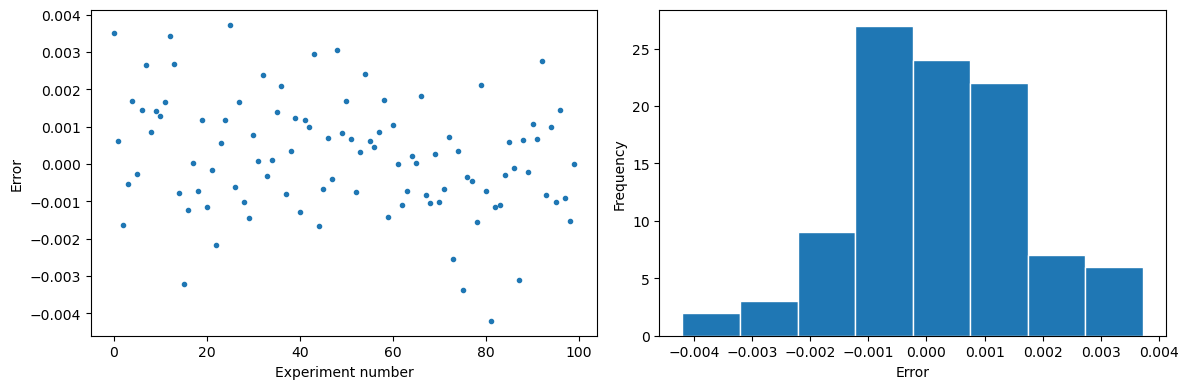

In [3]:
def ICA(x, mu, num_components, iters, mode):
    # Random initialization
    W = np.random.rand(num_components, num_components)
    N = np.size(x, 0)

    if mode=='superGauss':
        phi = lambda u : 2 * np.tanh(u)
    elif mode=='subGauss':
        phi = lambda u : u - np.tanh(u)
    else:
        print("Unknown mode")
        return W

    for i in range(iters):
        u = W @ x.T  # Projection of data onto weight matrix
        dW = (np.eye(num_components) - phi(u) @ u.T / N) @ W  # Gradient
        W += mu * dW  # Update rule
    return W

def generate_sources(num_samples):
    return np.random.uniform(0, 1, (2, num_samples))

def perform_experiment(num_samples, A, mu, components, iterations):
    s = generate_sources(num_samples)  # Generate sources
    x = (A @ s).T  # Mix sources
    x -= np.mean(x, axis=0)  # Centering the data
    
    W = ICA(x, mu, components, iterations, 'subGauss') # Run ICA
    A_hat = np.linalg.inv(W) # Estimated mixing matrix 
    W = np.divide(W, np.max(W)) # Normalize unmixing matrix
    z = (W@x.T).T # Compute unmixed signals
    return A_hat, x, s, z

def compute_error(A, A_hat):
    A_norm = A / np.max(A) # Normalize true mixing matrix
    A_hat_norm = A_hat / np.max(A_hat) # Normalize estimated mixing matrix
    return np.linalg.norm(A_norm, 'fro') - np.linalg.norm(A_hat_norm, 'fro')

# Parameters for ICA
mu = 0.1
components = 2
iterations = 1000

# Number of samples and experiments
num_samples = 50000
num_experiments = 100

A = np.array([[3, 1], [1, 1]])  # True mixing matrix

# Initialize lists to store results
A_hats = []
errors = []

# Run experiments 100 times
for i in range(num_experiments):
    # Compute A_hat
    A_hat, x, s, z = perform_experiment(num_samples, A, mu, components, iterations)
    A_hats.append(A_hat)

    # Compute error using Frobenius norm
    errors.append(compute_error(A, A_hat))
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(errors, '.')
plt.xlabel('Experiment number')
plt.ylabel('Error')

plt.subplot(1,2,2)
plt.hist(errors, bins=8, edgecolor='white')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('problem3_2_error.png', bbox_inches='tight', dpi=300)
plt.show()

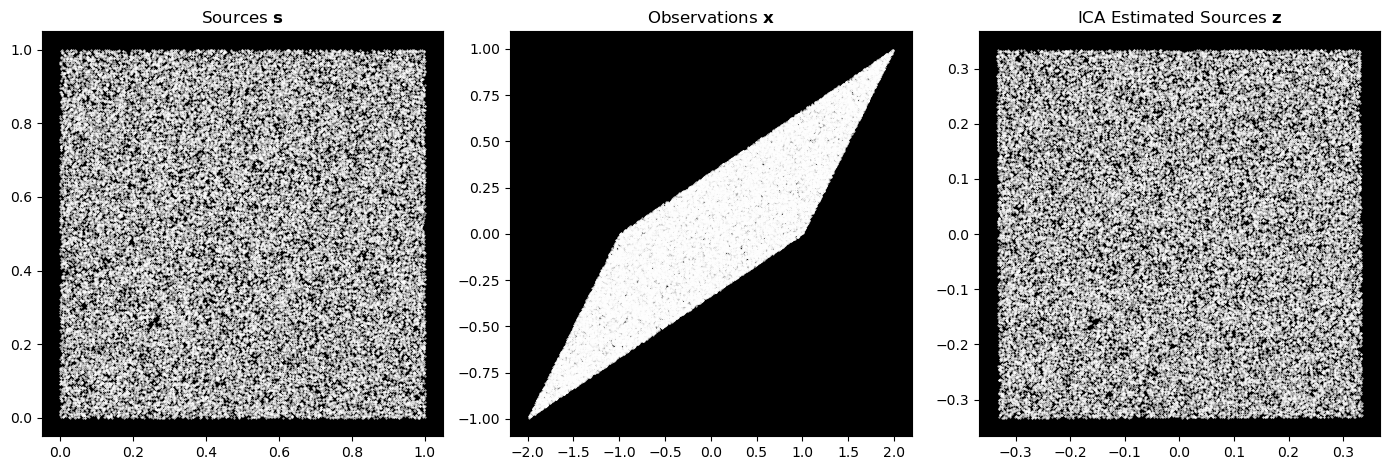

In [4]:
A_hat, x, s, z = perform_experiment(num_samples, A, mu, components, iterations)

# Plot sources

def plot_ICA(s, x, z, save_path=None):
    plt.figure(figsize=(14,4.8))
    plt.subplot(1,3,1)
    plt.plot(s.T[:,0],s.T[:,1],'.', markersize=0.8, color='white')
    plt.gca().set_facecolor('black')
    plt.title(r'Sources $\mathbf{s}$')

    # Plot generated data
    plt.subplot(1,3,2)
    plt.plot(x[:,0],x[:,1],'.', markersize=0.8, color='white')
    plt.gca().set_facecolor('black')
    plt.title(r'Observations $\mathbf{x}$')

    # Plot data projection on ICA axis
    plt.subplot(1,3,3)
    plt.plot(z[:,0],z[:,1],'.', markersize=0.8, color='white')
    plt.gca().set_facecolor('black')
    plt.title('ICA Estimated Sources $\mathbf{z}$')

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

plot_ICA(s, x, z, 'problem3_2_results.png')

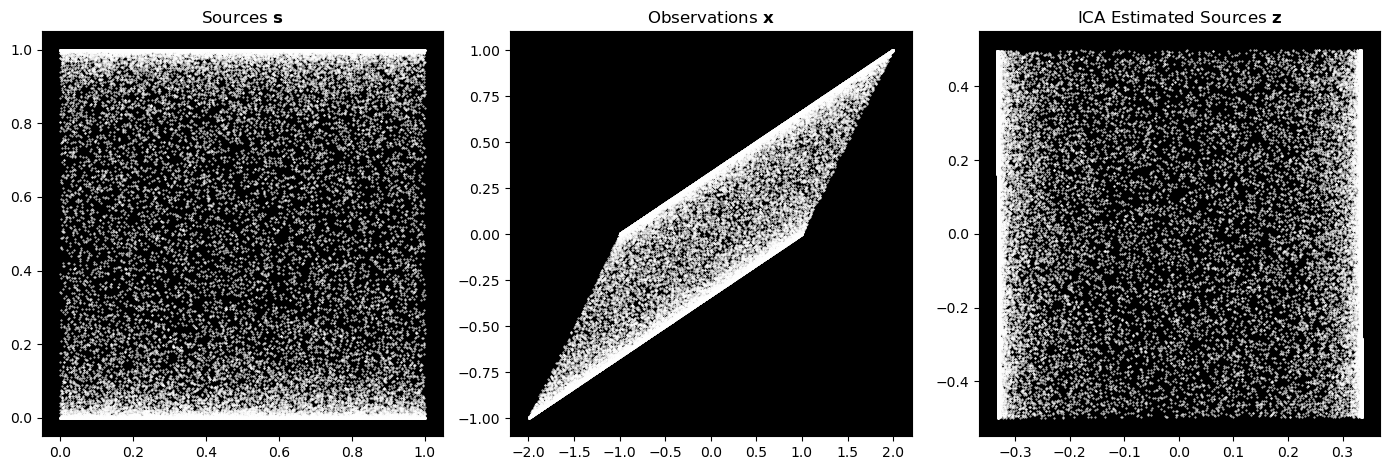

[[0.29595296 0.59862622]
 [0.29745097 0.19999598]]


In [5]:
# Case 1
def generate_sources(num_samples):
    s1 = np.random.uniform(0, 1, (1, num_samples))
    s2 = np.random.beta(0.1, 0.1, (1, num_samples))
    s = np.vstack((s1, s2))
    return s

A_hat, x, s, z = perform_experiment(num_samples, A, mu, components, iterations)
plot_ICA(s, x, z, '3_3beta.png')

print(A_hat)

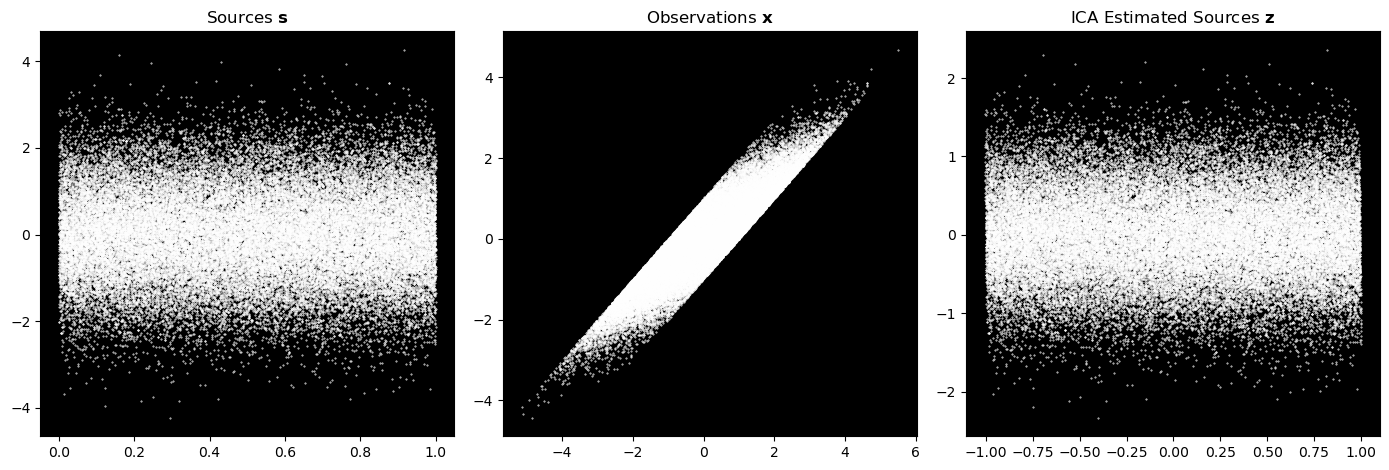

[[0.59523065 0.7217843 ]
 [0.19721593 0.72009724]]


In [6]:
# Case 2
def generate_sources(num_samples):
    s1 = np.random.uniform(0, 1, (1, num_samples))
    s2 = np.random.normal(0, 1, (1, num_samples))
    s = np.vstack((s1, s2))
    return s

A_hat, x, s, z = perform_experiment(num_samples, A, mu, components, iterations)
plot_ICA(s, x, z, '3_3normal.png')

print(A_hat)

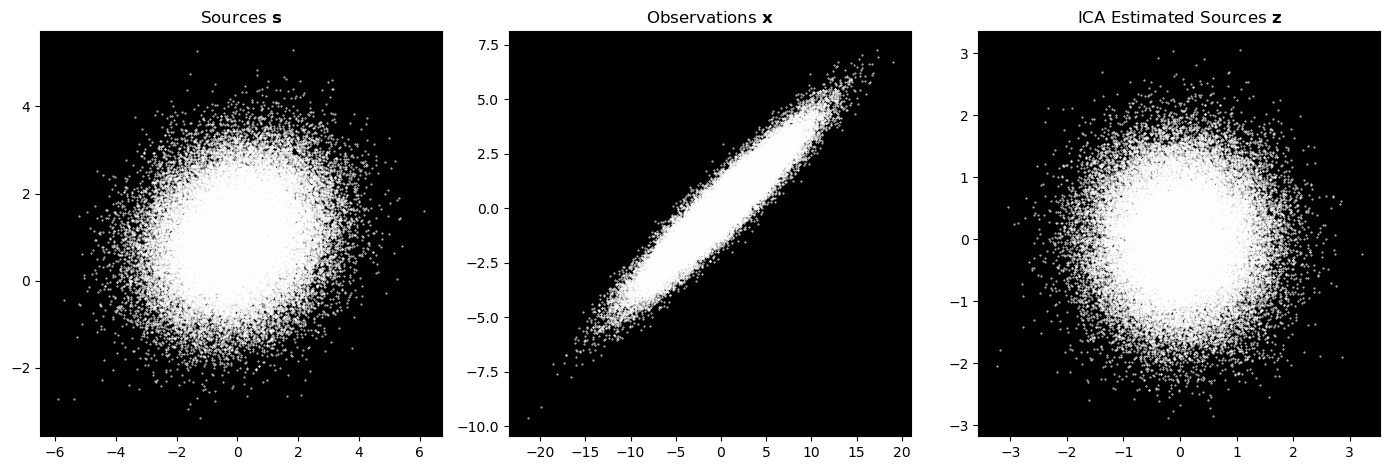

[[1.8326295  2.67616462]
 [1.07966821 0.79764978]]


In [7]:
# Case 3
def generate_sources(num_samples):
    s = np.random.multivariate_normal([0, 1], [[2, 0.25], [0.25, 1]], num_samples).T
    return s
A_hat, x, s, z = perform_experiment(num_samples, A, mu, components, iterations)
plot_ICA(s, x, z, '3_3multi.png')

print(A_hat)

### Problem 3.4

In [8]:
def initialize_hmm():
    """ Initialize the HMM model parameters. """
    # Initial state probabilities
    initial_probs = np.array([0.60, 0.40])
    
    # Transition probabilities
    transition_probs = np.array([
        [0.90, 0.10],  # From s1 to s1, s1 to s2
        [0.35, 0.65]   # From s2 to s1, s2 to s2
    ])
    
    # Emission probabilities
    emission_probs = np.array([
        [0.60, 0.30, 0.10],  # From s1 for a1, a2, a3
        [0.10, 0.60, 0.30]   # From s2 for a1, a2, a3
    ])
    
    return initial_probs, transition_probs, emission_probs

def forward_algorithm(observations, initial_probs, transition_probs, emission_probs):
    """ Perform the forward algorithm to calculate the filtering recursion coefficients. """
    num_states = len(initial_probs)
    num_observations = len(observations)
    
    # Initialize the alpha matrix
    alpha = np.zeros((num_observations, num_states))
    
    # Set initial alpha values for the first observation
    alpha[0] = initial_probs * emission_probs[:, observations[0]]
    
    # Compute alpha for subsequent observations
    for t in range(1, num_observations):
        for j in range(num_states):
            alpha[t, j] = np.sum(alpha[t-1] * transition_probs[:, j]) * emission_probs[j, observations[t]]
    
    return alpha

def calculate_conditional_probabilities(transition_probs, emission_probs):
    """ Compute the conditional probabilities P(y3 = a1 | x2 = s1) and P(y3 = a1 | x2 = s2). """
    # P(y3 = a1 | x2 = s1) = Sum over x3 of [P(y3 = a1 | x3) * P(x3 | x2 = s1)]
    py3_given_x2_s1 = np.sum(emission_probs[:, 0] * transition_probs[0])
    py3_given_x2_s2 = np.sum(emission_probs[:, 0] * transition_probs[1])
    
    return py3_given_x2_s1, py3_given_x2_s2

def main():
    initial_probs, transition_probs, emission_probs = initialize_hmm()
    
    # Mapping from activities to indices
    activities = {'a1': 0, 'a2': 1, 'a3': 2}
    
    # Observed sequence
    observed_sequence = ['a1', 'a2', 'a1']
    observation_indices = [activities[act] for act in observed_sequence]
    
    # Calculate the filtering recursion coefficients using the forward algorithm
    alpha = forward_algorithm(observation_indices, initial_probs, transition_probs, emission_probs)
    
    # Output results with 3 decimal places
    print("Problem 3.4.2:")
    for t in range(len(observed_sequence)):
        print(f"Time {t+1} (Observing {observed_sequence[t]}): {np.round(alpha[t], 3)}")
    
    # Calculate P(x2 = s1 | y1:2)
    # Normalize alpha values at t=1 to get probabilities
    prob_x2_s1_given_y1_y2 = alpha[1, 0] / np.sum(alpha[1])
    print(f"P(x2 = s1 | y1:2) = {prob_x2_s1_given_y1_y2:.3f}")

    print("\nProblem 3.4.3:")
    # Calculate the conditional probabilities
    py3_given_x2_s1, py3_given_x2_s2 = calculate_conditional_probabilities(transition_probs, emission_probs)
    
    # Print results with three decimal places
    print(f"P(y3 = a1 | x2 = s1) = {py3_given_x2_s1:.3f}")
    print(f"P(y3 = a1 | x2 = s2) = {py3_given_x2_s2:.3f}")

    print("\nProblem 3.4.4:")
    P_y3_given_x2_s1 = 0.55
    P_y3_given_x2_s2 = 0.275
    P_x2_s1_given_y1_y2 = 0.732  
    P_x2_s2_given_y1_y2 = 1-0.732  
    P_y3_given_y1_y2 = P_y3_given_x2_s1 * P_x2_s1_given_y1_y2 + P_y3_given_x2_s2 * P_x2_s2_given_y1_y2
    P_x2_s1_given_y1_y3 = (P_y3_given_x2_s1 * P_x2_s1_given_y1_y2) / P_y3_given_y1_y2
    print(f"P(x2 = s1 | y1:3) = {P_x2_s1_given_y1_y3:.3f}")

if __name__ == "__main__":
    main()


Problem 3.4.2:
Time 1 (Observing a1): [0.36 0.04]
Time 2 (Observing a2): [0.101 0.037]
Time 3 (Observing a1): [0.063 0.003]
P(x2 = s1 | y1:2) = 0.732

Problem 3.4.3:
P(y3 = a1 | x2 = s1) = 0.550
P(y3 = a1 | x2 = s2) = 0.275

Problem 3.4.4:
P(x2 = s1 | y1:3) = 0.845


### Problem 3.5

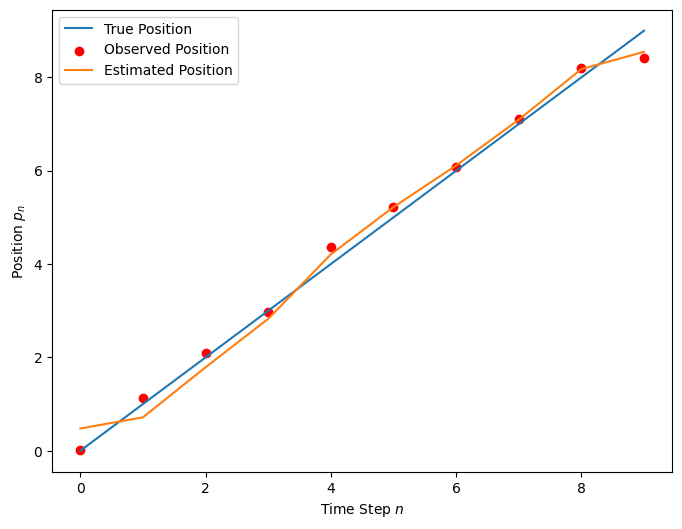

In [9]:
# Time step
dt = 1.0

# State transition matrix
F = np.array([[1, dt],
              [0, 1]])

# Observation matrix
H = np.array([[1, 0]])

# Process and measurement noise covariances
Q = np.array([[0.1, 0.0],
              [0.0, 0.1]])
R = np.array([[0.1]])

# Initial state and covariance
x_est = np.array([[0], [1]])  # Initial position 0, velocity 1
P = np.array([[1, 0],
              [0, 1]])

# Generate true data
true_position = [x_est[0, 0]]
true_velocity = [x_est[1, 0]]
for _ in range(9):
    x_est = F @ x_est
    true_position.append(x_est[0, 0])
    true_velocity.append(x_est[1, 0])

# Generate noisy observations
observations = true_position + np.random.normal(0, np.sqrt(R[0, 0]), 10)

# Kalman Filter
est_positions = []
est_velocities = []

for z in observations:
    # Prediction step
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q

    # Update step
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    y = z - H @ x_pred
    x_est = x_pred + K @ y
    P = (np.eye(2) - K @ H) @ P_pred

    est_positions.append(x_est[0, 0])
    est_velocities.append(x_est[1, 0])

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(true_position, label='True Position')
plt.scatter(range(len(observations)), observations, color='r', label='Observed Position')
plt.plot(est_positions, label='Estimated Position')
plt.xlabel(r'Time Step $n$')
plt.ylabel(r'Position $p_n$')
plt.legend()
plt.savefig('problem3_5.png', bbox_inches='tight', dpi=300)
plt.show()


### Problem 3.6

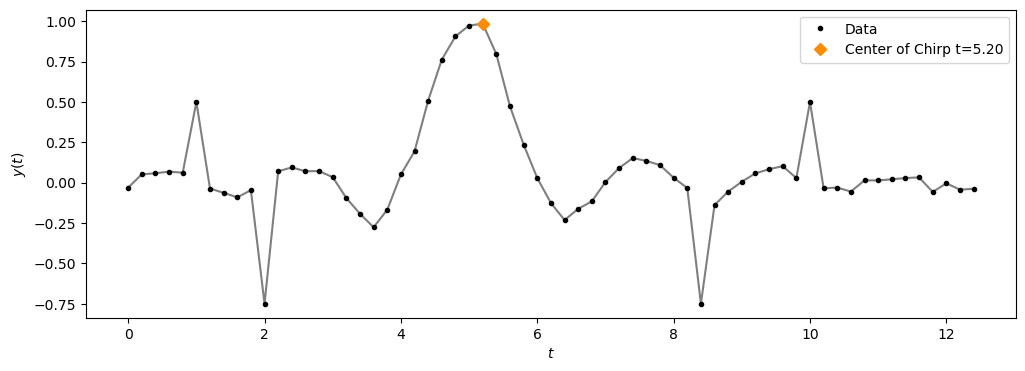

The center of the chirp is located at time index 26, which corresponds to t = 5.200.


In [10]:
# Load data
data = loadmat('problem3_6.mat')
t = data['t'].flatten() # Time indices
y = data['y'].flatten() # Signal values

# Determine the center location of the chirp
center_index = np.argmax(y)  # Index of the maximum value
center_time = t[center_index]  # Corresponding time value
center_amplitude = y[center_index] # Amplitude at the center

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, y, '.', color = 'black', label='Data')
plt.plot(t, y, '-', color = 'black', alpha = 0.5)
plt.plot(center_time, center_amplitude, 'D',  color = 'darkorange', label=f'Center of Chirp t={center_time:.2f}') 
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.legend()
plt.savefig('problem3_6_signal.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"The center of the chirp is located at time index {center_index}, which corresponds to t = {center_time:.3f}.")

Estimated SNR: 7.62 dB
The center of the chirp is located at time index 25, which corresponds to t = 5.000.


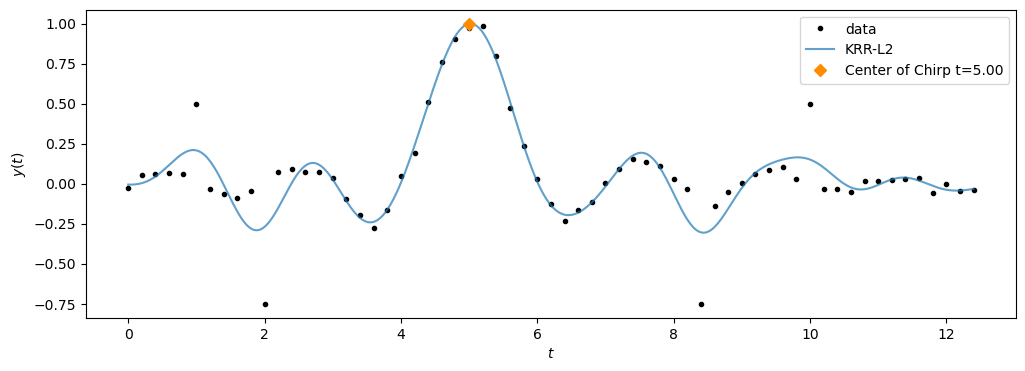

In [11]:
# Parameters
sigma = 1
C = 1e-2
N = len(y)

# Build kernel matrix
pair_dist = np.abs(t.reshape(-1, 1) - t.reshape(1, -1)) # solution  
K = np.exp(-1/(sigma**2)*pair_dist**2) # solution  
A = C*np.identity(N) + K # solution  
sol = np.linalg.solve(A, y)

samples = 1000 #Number of linspace points samples
tt = np.linspace(0,t[-1],samples)

# Generate regressor
z0 = np.zeros(samples)
for k in range(samples):
    z0[k] = 0
    for j in range(N):
        value = np.exp(-1/(sigma**2)*(t[j] - tt[k])**2)
        z0[k] += sol[j]*value

# Interpolating z0 back to the original time points t for SNR calculation
from scipy.interpolate import interp1d
interpolator = interp1d(tt, z0, kind='linear', fill_value="extrapolate")
z0_original_t = interpolator(t)

# Calculate SNR
signal_power = np.mean(z0_original_t**2)
noise_power = np.mean((y - z0_original_t)**2)
SNR = 10 * np.log10(signal_power / noise_power)
print(f"Estimated SNR: {SNR:.2f} dB")

# Determine the center location of the chirp
center_index = np.argmax(z0_original_t)  # Index of the maximum value
center_time = t[center_index]  # Corresponding time value
center_amplitude = z0_original_t[center_index] # Amplitude at the center
print(f"The center of the chirp is located at time index {center_index}, which corresponds to t = {center_time:.3f}.")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, y, '.',color = 'black', label='data')
plt.plot(tt, z0, label='KRR-L2', alpha = 0.7)
plt.plot(center_time, center_amplitude, 'D',  color = 'darkorange', label=f'Center of Chirp t={center_time:.2f}') 
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.legend()
plt.savefig('problem3_6_KRR.png', bbox_inches='tight', dpi=300)
plt.show()

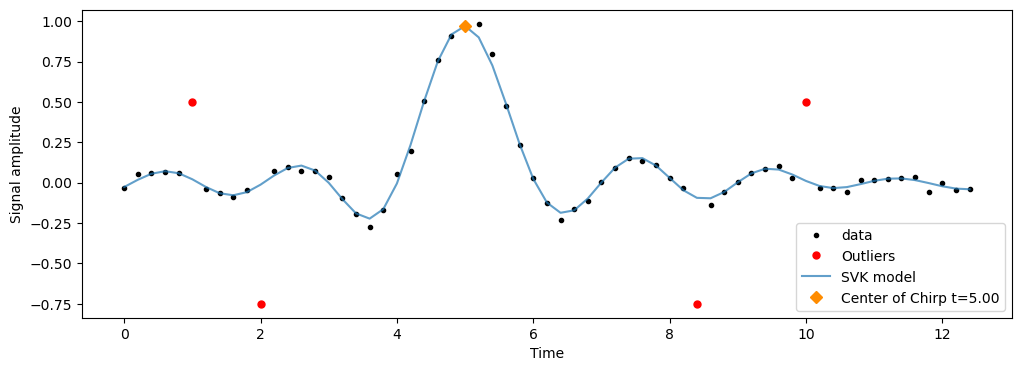

Estimated SNR (excluding outliers): 20.70 dB
Estimated center location of the chirp: t = 5.0


In [12]:
from sklearn.svm import SVR

# Setting up the SVR model
svr_rbf = SVR(kernel='rbf', C=1, gamma=1, epsilon=0.003)

# Fit data
svr_rbf.fit(t.reshape(-1, 1), y)

# Predict using the fitted model
y_pred = svr_rbf.predict(t.reshape(-1, 1))

# Outlier Detection
residuals = np.abs(y - y_pred)
outlier_threshold = np.percentile(residuals, 95)  # Simple rule: beyond 95th percentile
outliers = residuals > outlier_threshold

# Calculate SNR excluding outliers
signal_power = np.var(y_pred[~outliers])
noise_power = np.var((y - y_pred)[~outliers])
SNR = 10 * np.log10(signal_power / noise_power)

# Determine the center of the chirp
center_index = np.argmax(y_pred)
center_time = t[center_index]

# Plot the results
plt.figure(figsize=(12, 4))
plt.plot(t, y, '.', color = 'black', label='data')
plt.plot(t[outliers], y[outliers],'.', markersize = 10, color='r', label='Outliers')
plt.plot(t, y_pred, label='SVK model', alpha=0.7)
plt.plot(center_time, y_pred[center_index], 'D', color = 'darkorange', label=f'Center of Chirp t={center_time:.2f}') 
plt.xlabel('Time')
plt.ylabel('Signal amplitude')
plt.legend()
plt.savefig('problem3_6_SVR.png', bbox_inches='tight', dpi=300)
plt.show()


print(f"Estimated SNR (excluding outliers): {SNR:.2f} dB")
print(f"Estimated center location of the chirp: t = {center_time}")